In [1]:
location="psi"

In [2]:
import sys

sys.path += ["/mnt/t3nfs01/data01/shome/jpata/xgboost/python-package"]
#remove problematic cmssw python packages
newpath = []
for x in sys.path:
    if "/cvmfs/cms.cern.ch/" and "pandas" in x:
        continue
    newpath += [x]
sys.path = newpath

from collections import OrderedDict

if location=="jpata-macbook":
    sys.path.append("/Users/joosep/Documents/btv/CMSSW_7_4_5/src/RecoBTag/CombinedMVA/python/")
elif location=="psi":
    sys.path.append("/mnt/t3nfs01/data01/shome/jpata/btv/CMSSW_8_1_0_pre8/src/RecoBTag/CMSCSTagger/python/")

import numpy as np
import root_numpy as rnpy
import matplotlib.pyplot as plt
import pandas
import sklearn
import sklearn_cls
from sklearn_cls import SKLearnClassifier
from matplotlib.colors import LogNorm
import rootpy
import rootpy.plotting
from sklearn import metrics

%matplotlib inline
import ROOT

import xgboost

Welcome to ROOTaaS 6.06/01


In [3]:
import rootpy.plotting.root2matplotlib as rplt

Here we define the pt/eta binning for the kinematic weighting and for studying the pt/eta dependent performance of the tagger

In [4]:
ptbins = np.linspace(20, 620, 41)
ptbins2 = np.array([20, 30, 40, 50, 60, 70, 80, 100, 120, 140, 160, 200, 240, 280, 320, 360])

etabins = np.linspace(0, 2.5, 41)
etabins2 = np.linspace(0, 2.5, 11)

We load and pre-process the datasets. In particular, ***we clamp the CSV and SoftEl/SoftMu values between 0 and 1***.

In [5]:
# def load_dataset(fn, treename, i):
#     arr = rnpy.root2rec(
#         fn,
#         selection="Jet_pt>20",
#         #branches=["Jet_pt", "Jet_eta", "Jet_flavour"],
#         branches=["Jet_pt", "Jet_eta", "Jet_flavour", "Jet_CSV", "Jet_CSVIVF", "Jet_CombMVA", "Jet_CombMVANEW", "Jet_CombMVAETH", "Jet_SoftMu", "Jet_SoftEl", "Jet_JP", "Jet_JBP", "TagVarCSV_vertexCategory"],
#         treename=treename,
#         start=0,
#         stop=50000 #load only this many events for testing
#     )
#     df = pandas.DataFrame(arr)
    
#     df["id"] = i
#     df["label"] = 0
    
#     df[np.isnan(df)] = 0.0
#     df[np.isinf(df)] = 0.0
#     for c in ["Jet_CSV", "Jet_CSVIVF", "Jet_SoftEl", "Jet_SoftMu"]:
#         df.loc[df[c]<=0, c] = 0
#         df.loc[df[c]>=1, c] = 1
#     df["abs_eta"] = df["Jet_eta"].abs()
#     df["training"] = 0
    
#     #shuffle jets randomly between testing and training with a 50% probability
#     perminds = np.random.permutation(df.index)
#     df.loc[perminds[:len(perminds)/2], "training"] = 1
#     df["ptbin"] = map(lambda x: ptbins.searchsorted(x), df["Jet_pt"])
#     df["ptbin2"] = map(lambda x: ptbins2.searchsorted(x), df["Jet_pt"])
#     df["etabin"] = map(lambda x: etabins.searchsorted(x), df["abs_eta"])
#     df["etabin2"] = map(lambda x: etabins2.searchsorted(x), df["abs_eta"])
#     df["w"] = 1.0
#     return df

In [6]:
def load_dataset(fn):
    arr = rnpy.root2array(
        fn,
        selection="Jet_pt>20",
        branches=["Jet_pt", "Jet_eta", "Jet_flavour", "Jet_CSV", "Jet_CSVIVF", "Jet_cMVA", "Jet_SoftMu", "Jet_SoftEl", "Jet_JP", "Jet_JBP"],
        treename="tagVars/ttree",
        start=0,
        stop=50000 #load only this many events for testing
    )
    df = pandas.DataFrame(arr)
    df[np.isnan(df)] = 0.0
    df[np.isinf(df)] = 0.0
    
    df["flavour"] = 0
    df.loc[df["Jet_flavour"].abs() == 5, "flavour"] = 2
    df.loc[df["Jet_flavour"].abs() == 4, "flavour"] = 1

    df["is_b"] = 0
    df["is_c"] = 0
    df["is_l"] = 1
    
    bs = df["Jet_flavour"].abs()==5
    df.loc[bs, "is_b"] = 1
    df.loc[bs, "is_l"] = 0

    cs = df["Jet_flavour"].abs()==4
    df.loc[cs, "is_c"] = 1
    df.loc[cs, "is_l"] = 0
    
    df["weight"] = 1.0

    df["ptbin"] = map(lambda x: ptbins.searchsorted(x), df["Jet_pt"])
    df["ptbin2"] = map(lambda x: ptbins2.searchsorted(x), df["Jet_pt"])
    df["etabin"] = map(lambda x: etabins.searchsorted(x), df["Jet_eta"].abs())
    df["etabin2"] = map(lambda x: etabins2.searchsorted(x), df["Jet_eta"].abs())
    return df

Now we load all the datasets.
We have defined the jet flavours as follows:
  * flavour "0" - udsg
  * flavour "1" - c
  * flavour "2" - b

In [7]:
path = "/mnt/t3nfs01/data01/shome/jpata/btv/gc/TagVarExtractor/GCaacf2e5c69c5/TT_TuneCUETP8M1_13TeV-powheg-pythia8/"
dd = pandas.concat([
    load_dataset(path + "job_{0}_out.root".format(ij))
    for ij in range(19)
])

In [8]:
dd["flavour"].value_counts()

0    508536
2    321219
1    120245
Name: flavour, dtype: int64

In [9]:
# if location == "jpata-macbook":
#     path = "/Users/joosep/Documents/btv/data/aug10/"
# elif location == "psi":
#     path = "/home/joosep/btv/CMSSW_7_4_5/src/RecoBTag/CombinedMVA/"
# d1 = load_dataset(path + "ttjets_b_1M.root", "tree_b", 2)
# d2 = load_dataset(path + "ttjets_c_1M.root", "tree_c", 1)
# d3 = load_dataset(path + "ttjets_l_1M.root", "tree_l", 0)

Let's take a quick look at what we have.

In [10]:
dd.head()

,Jet_pt,Jet_eta,Jet_flavour,Jet_CSV,Jet_CSVIVF,Jet_cMVA,Jet_SoftMu,Jet_SoftEl,Jet_JP,Jet_JBP,flavour,is_b,is_c,is_l,weight,ptbin,ptbin2,etabin,etabin2
0,152.416916,-0.501351,-5.0,0.994858,0.991477,0.999587,0.0,0.0,1.224206,5.561194,2,1,0,0,1.0,9,10,9,3
1,135.050537,0.246850,5.0,0.977483,0.953352,0.974995,0.0,0.0,1.046432,4.985117,2,1,0,0,1.0,8,9,4,1
2,22.593838,1.810297,21.0,0.145810,0.145810,-0.979260,0.0,0.0,-0.000000,0.015422,0,0,0,1,1.0,1,1,29,8
3,54.100124,0.035017,21.0,0.121755,0.121755,-0.972495,0.0,0.0,0.130564,0.443545,0,0,0,1,1.0,3,4,1,1
4,30.963558,-2.281839,1.0,0.136818,0.136818,-0.976465,0.0,0.0,0.021256,0.090827,0,0,0,1,1.0,1,2,37,10


Now we also load the QCD datasets.

In [11]:
# d1_qcd = load_dataset(path + "qcd_b_1M.root", "tree_b", 2)
# d2_qcd = load_dataset(path + "qcd_c_1M.root", "tree_c", 1)
# d3_qcd = load_dataset(path + "qcd_l_1M.root", "tree_l", 0)
# d_qcd = pandas.concat((d1_qcd, d2_qcd, d3_qcd))

In [12]:
# d_training_shuf.head(1000).to_csv("/Users/joosep/Desktop/data.csv")

In [13]:
#d.to_csv("/Users/joosep/Desktop/data.csv")

We split to training and testing according to a jet-by-jet random shuffle defined when the datasets are loaded. 

In [14]:
# d_training = d[d["training"]==1]
# d_testing = d[d["training"]==0]

Now we calculate the kinematic weights.

In [15]:
ptbins_w = np.linspace(20, 620, 101)
etabins_w = np.linspace(0, 2.5, 101)
def get_weights(df):
    vs, bx, by = np.histogram2d(
        df["Jet_pt"],
        df["Jet_eta"].abs(),
        bins=[ptbins_w, etabins_w]
    )
    vs = vs / float(np.sum(vs))
    ws = 1.0/vs
    ws[np.isnan(ws)]=0.0
    ws[np.isnan(ws)]=0.0
    ws[np.isinf(ws)]=1
    ws[np.isinf(ws)]=1
    return ws

In [16]:
weight_b = get_weights(dd[dd["is_b"]==1])
weight_c = get_weights(dd[dd["is_c"]==1])
weight_l = get_weights(dd[dd["is_c"]==1])

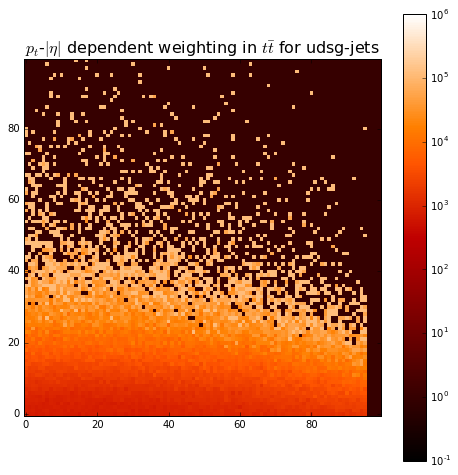

In [17]:
plt.figure(figsize=(8,8))
plt.title("$p_t$-$|\eta|$ dependent weighting in $t\\bar{t}$ for udsg-jets", fontsize=16)
z = plt.imshow(weight_l, interpolation="none",origin="lower",norm=LogNorm(vmin=0.1,vmax=1000000.0), cmap="gist_heat")
plt.colorbar(z)
plt.savefig("weights_light.pdf")

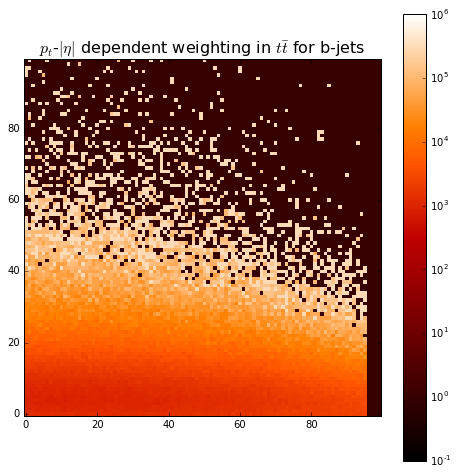

In [18]:
plt.figure(figsize=(8,8))
plt.title("$p_t$-$|\eta|$ dependent weighting in $t\\bar{t}$ for b-jets", fontsize=16)
z = plt.imshow(weight_b, interpolation="none",origin="lower",norm=LogNorm(vmin=0.1,vmax=1000000.0), cmap="gist_heat")
plt.colorbar(z)
plt.savefig("weights_b.pdf")

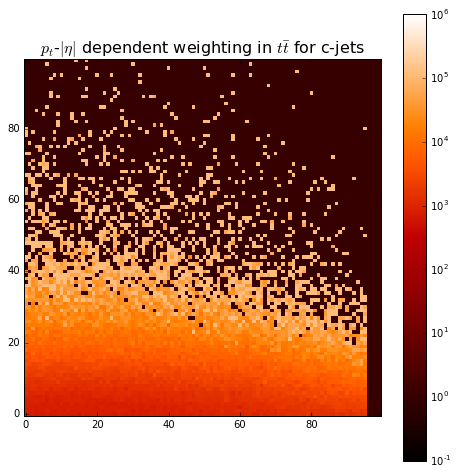

In [19]:
plt.figure(figsize=(8,8))
plt.title("$p_t$-$|\eta|$ dependent weighting in $t\\bar{t}$ for c-jets", fontsize=16)
z = plt.imshow(weight_c, interpolation="none",origin="lower",norm=LogNorm(vmin=0.1,vmax=1000000.0), cmap="gist_heat")
plt.colorbar(z)
plt.savefig("weights_charm.pdf")

In [20]:
def weight(pt, eta, fl):
    ibx = ptbins_w.searchsorted(pt) - 1
    iby = etabins_w.searchsorted(abs(eta)) - 1
    if ibx < 0:
        ibx = 0
    if iby < 0:
        iby = 0
    if ibx>=len(ptbins_w)-1:
        ibx = len(ptbins_w)-2
    if iby>=len(etabins_w)-1:
        iby = len(etabins_w)-2
        
    if fl == 2:
        ws = weight_b
    elif fl == 1:
        ws = weight_c
    elif fl==0:
        ws = weight_l
    return ws[ibx, iby]  

In [21]:
dd["w"] = 1.0

In [22]:
# d["w"]  = map(
#     lambda _z: weight(_z[0], _z[1], _z[2]),
#     zip(dd["Jet_pt"], dd["Jet_eta"].abs(), dd["id"])
# )

# d["w2"] = 1
# d.loc[d["id"]==0, "w2"] = 0.5
# d.loc[d["id"]==1, "w2"] = 0.5

In [23]:
def draw_corr(data, v1, vn1, v2, vn2, title):

    c = (np.abs(data["Jet_CSV"] -
         data["Jet_CSVIVF"])>0.00000000001
    )
    hd = np.histogram2d(
        data[c][v1],
        data[c][v2],
        bins=[np.linspace(0,1,21), np.linspace(0,1,21)]
    )
    hd = hd[0] / float(np.sum(hd[0]))
    corr = np.corrcoef(
        data[c][v1],
        data[c][v2]
    )

    plt.figure(figsize=(6,5))
    ax = plt.axes()
    ret = ax.imshow(
        hd,
        cmap="hot",
        interpolation="none",
        origin="lower",
        aspect="auto",
        #vmin=0,
        #vmax=60000,
        extent=[
            0,
            1,
            0,
            1
        ],
        norm=LogNorm(vmin=0.000001, vmax=1)
    )
    plt.title(title + " corr={0:.4f}".format(corr[0,1]), fontsize=16)
    plt.xlabel(vn1, fontsize=16)
    plt.ylabel(vn2, fontsize=16)
    plt.colorbar(ret)

Pt distribution before and after reweighting.

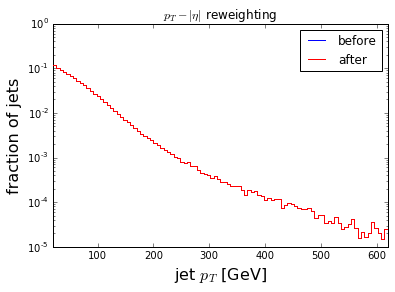

In [24]:
h = rootpy.plotting.Hist(100, 20, 620)
w = np.ones(len(dd), dtype="float64")
h.FillN(len(dd), np.array(dd["Jet_pt"]).astype("float64"), w)
h.Scale(1.0 / h.Integral())
h.color="blue"
rplt.hist(h, color="blue", label="before")

h2 = rootpy.plotting.Hist(100, 20, 620)
h2.FillN(len(dd), np.array(dd["Jet_pt"]).astype("float64"), np.array(dd["w"]).astype("float64"))
h2.Scale(1.0 / h2.Integral())
h2.color="red"
rplt.hist(h2, color="red", label="after")

plt.yscale("log")
plt.ylim(10**-5, 1)
plt.xlabel("jet $p_T$ [GeV]", fontsize=16)
plt.ylabel("fraction of jets", fontsize=16)
plt.legend()
plt.title("$p_T-|\eta|$ reweighting")
plt.savefig("pt_reweight.pdf")

Eta distribution before and after reweighting.

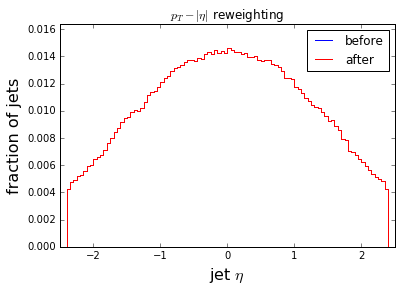

In [25]:
h = rootpy.plotting.Hist(100, -2.5, 2.5)
w = np.ones(len(dd), dtype="float64")
h.FillN(len(dd), np.array(dd["Jet_eta"]).astype("float64"), w)
h.Scale(1.0 / h.Integral())
h.color="blue"
rplt.hist(h, color="blue", label="before")

h2 = rootpy.plotting.Hist(100, -2.5, 2.5)
h2.FillN(len(dd), np.array(dd["Jet_eta"]).astype("float64"), np.array(dd["w"]).astype("float64"))
h2.Scale(1.0 / h2.Integral())
h2.color="red"
rplt.hist(h2, color="red", label="after")

#plt.yscale("log")
#plt.ylim(10**-5, 1)
plt.xlabel("jet $\eta$", fontsize=16)
plt.ylabel("fraction of jets", fontsize=16)
plt.legend()
plt.title("$p_T-|\eta|$ reweighting")
plt.savefig("eta_reweight.pdf")

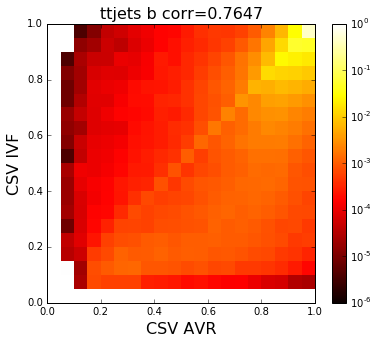

In [26]:
draw_corr(dd[dd["is_b"]==1], "Jet_CSV", "CSV AVR", "Jet_CSVIVF", "CSV IVF", "ttjets b")
plt.savefig("corr_csv_avr_ivf_b.pdf")

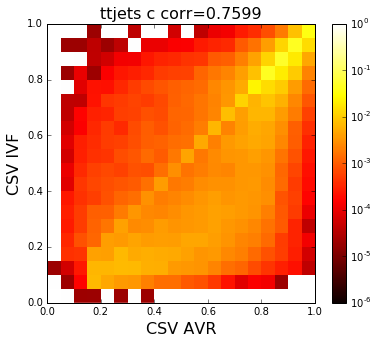

In [27]:
draw_corr(dd[dd["is_c"]==1], "Jet_CSV", "CSV AVR", "Jet_CSVIVF", "CSV IVF", "ttjets c")
plt.savefig("corr_csv_avr_ivf_charm.pdf")

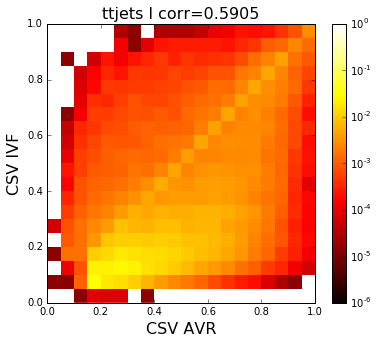

In [28]:
draw_corr(dd[dd["is_l"]==1], "Jet_CSV", "CSV AVR", "Jet_CSVIVF", "CSV IVF", "ttjets l")
plt.savefig("corr_csv_avr_ivf_light.pdf")

In [29]:
def cum(arr, nb=100000):
    h = np.histogram(
        arr,
        bins=np.linspace(-1, 1, nb)
    )
    h = h[0]
    h = h / float(np.sum(h))
    h = np.cumsum(h)
    return h

In [30]:
def cumerr(arr, nb=100000):
    h = np.histogram(
        arr,
        bins=np.linspace(np.min(arr), np.max(arr),nb)
    )
    h = h[0]
    hc = np.cumsum(h)
    he = np.sqrt(np.cumsum(h))
    hc = hc / float(np.sum(h))
    he = he / float(np.sum(h))
    return hc, he

Set light-jet weight to 30% to give less emphasis to udgs.
**Note: we de-emphasize the effect of light jets in the training**

In [31]:
# d_training.iloc[d_training["id"]==0, "w"] *= 0.3

In [33]:
vs = ["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl"]

In [162]:
cls2 = xgboost.XGBClassifier(
    n_estimators=100,
    nthread=32,
    silent=False
)

In [164]:
cls2.fit(
    dd[vs],
    dd["flavour"],
    verbose=True
)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=32,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

In [175]:
dd_cls2 = cls2.predict_proba(dd[vs])

In [176]:
dd["cls2_p0"] = dd_cls2[:, 0]
dd["cls2_p1"] = dd_cls2[:, 1]
dd["cls2_p2"] = dd_cls2[:, 2]

In [186]:
def compare_classes(c1, c2, dd, probas):
    is_c1 = dd["flavour"] == c1
    is_c2 = dd["flavour"] == c2
    rocs = []
    for cls_proba in probas:
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            dd.loc[is_c1|is_c2, "flavour"] == c1,
            dd.loc[is_c1|is_c2, cls_proba]
        )
        rocs += [(fpr, tpr, cls_proba)]
    return rocs

In [201]:
rocs_b_l = compare_classes(2, 0, dd, ["Jet_CSVIVF", "Jet_cMVA", "cls_p2"])
rocs_b_c = compare_classes(2, 1, dd, ["Jet_CSVIVF", "Jet_cMVA", "cls_p2"])
rocs_c_l = compare_classes(1, 0, dd, ["Jet_CSVIVF", "Jet_cMVA", "cls_p1"])

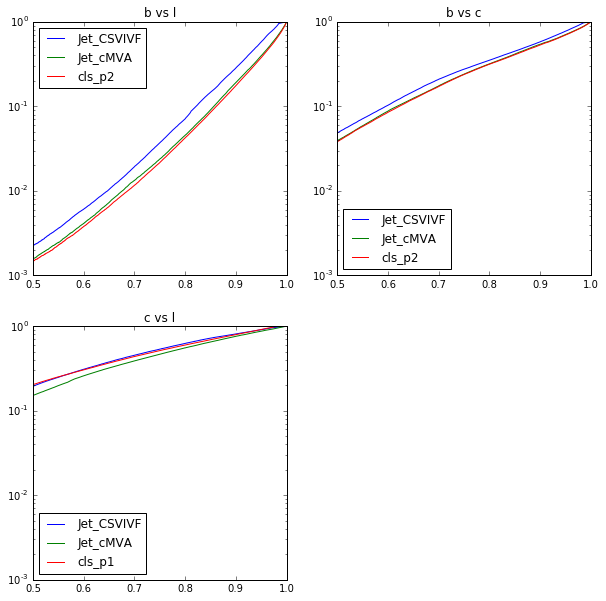

In [202]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
for fpr, tpr, label in rocs_b_l:
    plt.plot(tpr, fpr, label=label)
plt.title("b vs l")
plt.yscale("log")
plt.xlim(0.5, 1.0)
plt.ylim(0.001, 1.0)
plt.legend(loc="best")

plt.subplot(2,2,2)
for fpr, tpr, label in rocs_b_c:
    plt.plot(tpr, fpr, label=label)
plt.title("b vs c")
plt.yscale("log")
plt.xlim(0.5, 1.0)
plt.ylim(0.001, 1.0)
plt.legend(loc="best")

plt.subplot(2,2,3)
for fpr, tpr, label in rocs_c_l:
    plt.plot(tpr, fpr, label=label)
    
plt.title("c vs l")
plt.yscale("log")
plt.xlim(0.5, 1.0)
plt.ylim(0.001, 1.0)
plt.legend(loc="best")

# Validation

Now we separate test and training datasets as matrices.

In [40]:
X_test = d_testing[cls_c4.variables]
y_test = d_testing["id"]

X_train = d_training[cls_c4.variables]
y_train = d_training["id"]

Now we calculate the loss function of the classifier on each stage of training.

In [41]:
test_score = np.zeros((cls_c4.cls.n_estimators, ), dtype=np.float64)

for i, y_pred in enumerate(cls_c4.cls.staged_decision_function(X_test)):
    test_score[i] = cls_c4.cls.loss_(y_test, y_pred)

In [42]:
train_score = np.zeros((cls_c4.cls.n_estimators, ), dtype=np.float64)

for i, y_pred in enumerate(cls_c4.cls.staged_decision_function(X_train)):
    train_score[i] = cls_c4.cls.loss_(y_train, y_pred)

We see that the loss function decreases (becomes better) upon more boosting iterations.

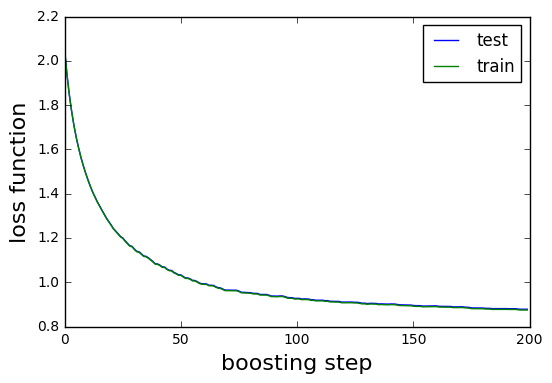

In [43]:
plt.plot(test_score, label="test")
plt.plot(train_score, label="train")
plt.legend(loc="best")
plt.xlabel("boosting step", fontsize=16)
plt.ylabel("loss function", fontsize=16)
plt.savefig("loss_test_train.pdf")

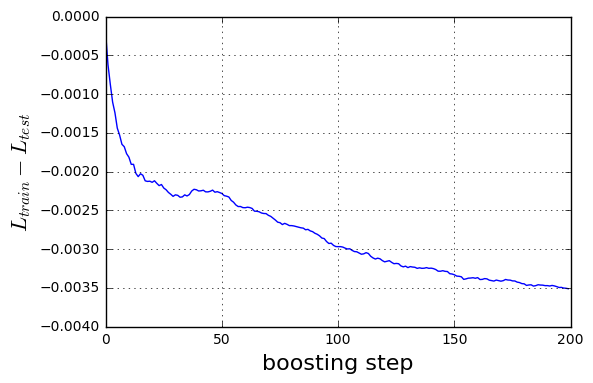

In [44]:
plt.plot(train_score - test_score)
#plt.yscale("log")
plt.ylabel("$L_{train} - L_{test}$", fontsize=16)
plt.xlabel("boosting step", fontsize=16)
plt.grid()
plt.savefig("lossdif_test_train.pdf")

In [45]:
def calc_roc(h1, h2):
    h1 = h1.Clone()
    h2 = h2.Clone()
    h1.Scale(1.0 / h1.Integral())
    h2.Scale(1.0 / h2.Integral())
    roc = np.zeros((h1.GetNbinsX()+2, 2))
    err = np.zeros((h1.GetNbinsX()+2, 2))
    e1 = ROOT.Double(0)
    e2 = ROOT.Double(0)
    for i in range(0, h1.GetNbinsX()+2):
        I1 = h1.Integral(0, h1.GetNbinsX())
        I2 = h2.Integral(0, h2.GetNbinsX())
        if I1>0 and I2>0:
            roc[i, 0] = float(h1.IntegralAndError(i, h1.GetNbinsX()+2, e1)) / I1
            roc[i, 1] = float(h2.IntegralAndError(i, h1.GetNbinsX()+2, e2)) / I2
            err[i, 0] = e1
            err[i, 1] = e2
    return roc, err
def draw_rocs(pairs, **kwargs):
    rebin = kwargs.get("rebin", 1) 
    rs = []
    es = []
    for pair in pairs:
        h1, h2, label, pl_args = pair
        h1.rebin(rebin)
        h2.rebin(rebin)
        r, e = calc_roc(h1, h2)
        rs += [r]
        es += [e]

    ret = []
    for (r, e, pair) in zip(rs, es, pairs):
        h1, h2, label, pl_args = pair
        c1 = rootpy.asrootpy(h1.GetCumulative())
        c2 = rootpy.asrootpy(h2.GetCumulative())
        c1.Scale(1.0 / h1.Integral())
        c2.Scale(1.0 / h2.Integral())
        bx = list(c1.y())
        by = list(c2.y())
        a = 1.0 - sklearn.metrics.auc(bx, by)
        #plt.errorbar(r[:, 0], r[:, 1], e[:, 0], e[:, 1], label=label)
        r = plt.plot(r[:, 0], r[:, 1], label=label, **pl_args)
        ret += [r]
    return ret
    plt.legend(loc=2)

### Performance in $t\bar{t}$ + jets.

In [46]:
md = {"b":d_testing[d_testing["id"]==2], "l":d_testing[d_testing["id"]==0], "c":d_testing[d_testing["id"]==1]}
md_tr = {"b":d_training[d_training["id"]==2], "l":d_training[d_training["id"]==0], "c":d_training[d_training["id"]==1]}

h01 = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CSV"].as_matrix(), lambda d: d["w"].as_matrix())
h02 = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CSVIVF"].as_matrix(), lambda d: d["w"].as_matrix())
#h03 = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CombMVA"].as_matrix(), lambda d: d["w"].as_matrix())
h04 = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CombMVANEW"].as_matrix(), lambda d: d["w"].as_matrix())
h05 = cls_c1.hists((250,-1,1), md, lambda d: d["Jet_CombMVAETH"].as_matrix(), lambda d: d["w"].as_matrix())

ha = cls_ca.hists_cls((250,-1,1), md)
h0 = cls_c0.hists_cls((250,-1,1), md)
h1 = cls_c1.hists_cls((250,-1,1), md)
h2 = cls_c2.hists_cls((250,-1,1), md)
h3 = cls_c3.hists_cls((250,-1,1), md)
h4 = cls_c4.hists_cls((250,-1,1), md)
h5 = cls_c5.hists_cls((250,-1,1), md)

In [47]:
#h_ts = cls_c1.hists((250,-1,1), lambda d: d["Jet_CombMVAETH"].as_matrix(), lambda d: d["w"].as_matrix(), md)
#h_tr = cls_c1.hists((250,-1,1), lambda d: d["Jet_CombMVAETH"].as_matrix(), lambda d: d["w"].as_matrix(), md_tr)

h_ts = cls_c4.hists_cls((100,-1,1), md)
h_tr = cls_c4.hists_cls((100,-1,1), md_tr)

We compare the test and training performances.

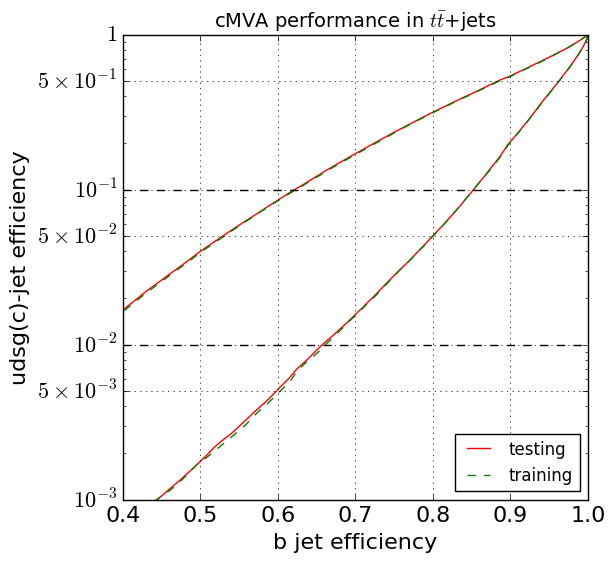

In [48]:
plt.figure(figsize=(6,6))
ax = plt.axes()
plt.grid()
r = draw_rocs([
    (h_ts["b"], h_ts["l"], "testing", {"color":"red"}),
    (h_tr["b"], h_tr["l"], "training", {"color":"green", "ls": "--"}),
])

plt.legend(loc=4)
r = draw_rocs([
    (h_ts["b"], h_ts["c"], "testing", {"color":"red"}),
    (h_tr["b"], h_tr["c"], "training", {"color":"green", "ls": "--"}),
])

plt.yscale("log")

a = [0.5, 1.0]
a = [0.001, 0.005, 0.01, 0.05, 0.1] + list(a)
plt.yticks(a, a)
plt.xlim(0.4,1.0)
plt.ylim(0.001,1.0)
plt.axhline(0.01, color="black", ls="--")
plt.axhline(0.1, color="black", ls="--")

plt.xticks(np.linspace(0.4,1.0,7), fontsize=16)
plt.ylabel("udsg(c)-jet efficiency", fontsize=16)
plt.xlabel("b jet efficiency", fontsize=16)
plt.title(u"cMVA performance in $t\\bar{t}$+jets", fontsize=14)
ax.set_yticklabels(
    ["$10^{-3}$", "$5 \\times 10^{-3}$", "$10^{-2}$", "$5 \\times 10^{-2}$", "$10^{-1}$", "$5 \\times 10^{-1}$", "$1$"],
    fontsize=16
)
plt.savefig("cmva_test_training_perf_roc_ttjets.pdf")

Here we compare the shapes of the test and training distributions.

In [49]:
for k in ["b", "c", "l"]:
    h_ts[k].Rebin(5)
    h_tr[k].Rebin(5)
    h_ts[k].Divide(h_tr[k])
    
h_ts["b"].color = "red"
h_ts["c"].color = "blue"
h_ts["l"].color = "green"

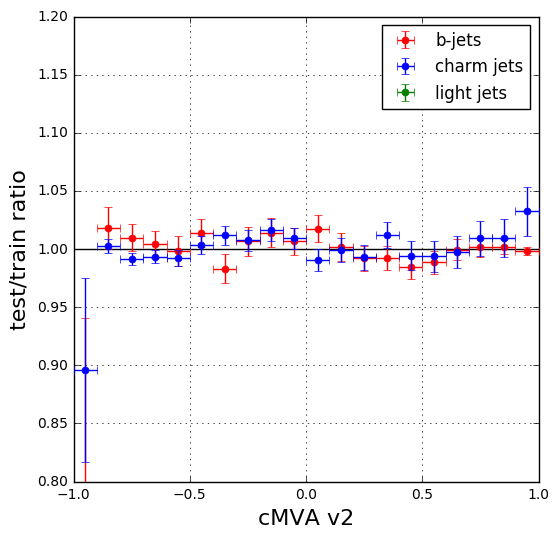

In [50]:
plt.figure(figsize=(6,6))
rplt.errorbar(h_ts["b"], label="b-jets")
rplt.errorbar(h_ts["c"], label="charm jets")
rplt.errorbar(h_ts["l"], label="light jets")

plt.ylim(0.8,1.2)
plt.axhline(1.0, color="black")
plt.grid()
plt.xlabel("cMVA v2", fontsize=16)
plt.ylabel("test/train ratio", fontsize=16)
plt.legend(numpoints=1)
plt.savefig("cmva_test_training_shape.pdf")

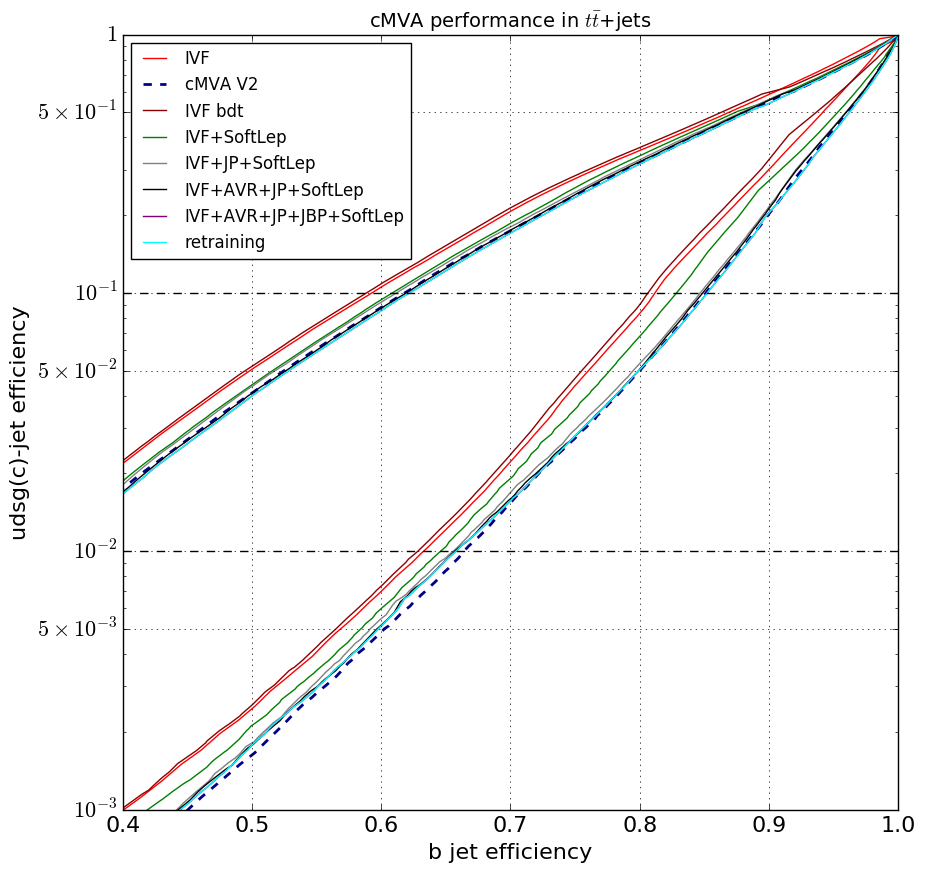

In [51]:
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.grid()
r = draw_rocs([
    #(h01["b"], h01["l"], "AVR", {"color":"red"}),
    (h02["b"], h02["l"], "IVF", {"color":"red"}),
    #(h04["b"], h04["l"], "cMVA", {"color":"orange", "lw":2}),
    (h05["b"], h05["l"], "cMVA V2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["l"], "tmva", {"color":"orange"}),
    (ha["b"], ha["l"], "IVF bdt", {"color": "darkred", "lw":1}),
    (h0["b"], h0["l"], "IVF+SoftLep", {"color": "green", "lw":1}),
    (h1["b"], h1["l"], "IVF+JP+SoftLep", {"color": "grey", "lw":1}),
    (h2["b"], h2["l"], "IVF+AVR+JP+SoftLep", {"color": "black", "lw":1}),
    (h3["b"], h3["l"], "IVF+AVR+JP+JBP+SoftLep", {"color": "purple", "lw":1}),
    (h4["b"], h4["l"], "retraining", {"color": "cyan", "lw":1}),
    #(h5["b"], h5["l"], "c5", {"color": "gray", "lw":1}),
])

plt.legend(loc="best")
r = draw_rocs([
    #(h01["b"], h01["c"], "AVR", {"color":"red"}),
    (h02["b"], h02["c"], "IVF", {"color":"red"}),
    #(h04["b"], h04["c"], "cMVA", {"color":"orange", "lw":2}),
    (h05["b"], h05["c"], "cMVA V2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["c"], "tmva", {"color":"orange"}),
    (ha["b"], ha["c"], "IVF bdt", {"color": "darkred", "lw":1}),
    (h0["b"], h0["c"], "IVF+SoftLep", {"color": "green", "lw":1}),
    (h1["b"], h1["c"], "IVF+JP+SoftLep", {"color": "grey", "lw":1}),
    (h2["b"], h2["c"], "IVF+AVR+JP+SoftEl", {"color": "black", "lw":1}),
    (h3["b"], h3["c"], "IVF+AVR+JP+JBP+SoftEl", {"color": "purple", "lw":1}),
    (h4["b"], h4["c"], "retraining", {"color": "cyan", "lw":1}),
    #(h5["b"], h5["c"], "c5", {"color": "gray", "lw":1}),
])

plt.yscale("log")

a = [0.5, 1.0]
a = [0.001, 0.005, 0.01, 0.05, 0.1] + list(a)
plt.yticks(a, a)
plt.xlim(0.4,1.0)
plt.ylim(0.001,1.0)
plt.axhline(0.01, color="black", ls="--")
plt.axhline(0.1, color="black", ls="--")

plt.xticks(np.linspace(0.4,1.0,7), fontsize=16)
plt.ylabel("udsg(c)-jet efficiency", fontsize=16)
plt.xlabel("b jet efficiency", fontsize=16)
plt.title(u"cMVA performance in $t\\bar{t}$+jets", fontsize=14)
ax.set_yticklabels(
    ["$10^{-3}$", "$5 \\times 10^{-3}$", "$10^{-2}$", "$5 \\times 10^{-2}$", "$10^{-1}$", "$5 \\times 10^{-1}$", "$1$"],
    fontsize=16
)
plt.savefig("mva_separate_trainings_ttjets.pdf")

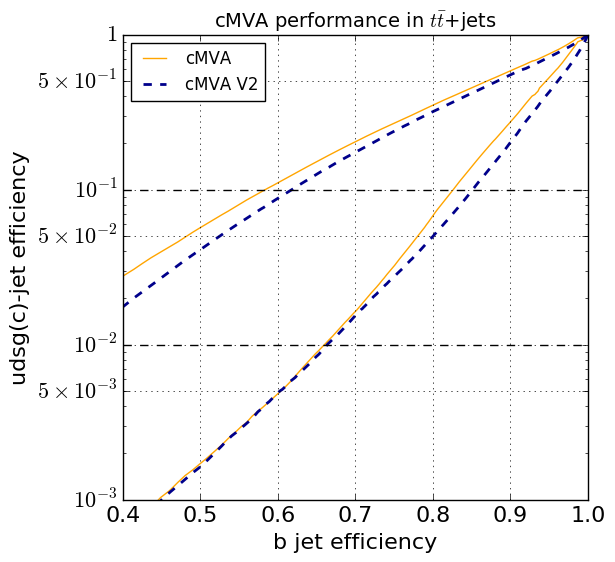

In [52]:
plt.figure(figsize=(6,6))
ax = plt.axes()
plt.grid()
r = draw_rocs([
    #(h01["b"], h01["l"], "AVR", {"color":"red"}),
    #(h02["b"], h02["l"], "IVF", {"color":"red"}),
    (h04["b"], h04["l"], "cMVA", {"color":"orange"}),
    (h05["b"], h05["l"], "cMVA V2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["l"], "tmva", {"color":"orange"}),
    #(ha["b"], ha["l"], "IVF bdt", {"color": "darkred", "lw":1}),
    #(h0["b"], h0["l"], "IVF+SoftLep", {"color": "green", "lw":1}),
    #(h1["b"], h1["l"], "IVF+JP+SoftLep", {"color": "grey", "lw":1}),
    #(h2["b"], h2["l"], "IVF+AVR+JP+SoftLep", {"color": "black", "lw":1}),
    #(h3["b"], h3["l"], "IVF+AVR+JP+JBP+SoftLep", {"color": "purple", "lw":1}),
    #(h4["b"], h4["l"], "retraining", {"color": "cyan", "lw":1}),
    #(h5["b"], h5["l"], "c5", {"color": "gray", "lw":1}),
])

plt.legend(loc="best")
r = draw_rocs([
    #(h01["b"], h01["c"], "AVR", {"color":"red"}),
    #(h02["b"], h02["c"], "IVF", {"color":"red"}),
    (h04["b"], h04["c"], "cMVA", {"color":"orange"}),
    (h05["b"], h05["c"], "cMVA V2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["c"], "tmva", {"color":"orange"}),
    #(ha["b"], ha["c"], "IVF bdt", {"color": "darkred", "lw":1}),
    #(h0["b"], h0["c"], "IVF+SoftLep", {"color": "green", "lw":1}),
    #(h1["b"], h1["c"], "IVF+JP+SoftLep", {"color": "grey", "lw":1}),
    #(h2["b"], h2["c"], "IVF+AVR+JP+SoftEl", {"color": "black", "lw":1}),
    #(h3["b"], h3["c"], "IVF+AVR+JP+JBP+SoftEl", {"color": "purple", "lw":1}),
    #(h4["b"], h4["c"], "retraining", {"color": "cyan", "lw":1}),
    #(h5["b"], h5["c"], "c5", {"color": "gray", "lw":1}),
])

plt.yscale("log")

a = [0.5, 1.0]
a = [0.001, 0.005, 0.01, 0.05, 0.1] + list(a)
plt.yticks(a, a)
plt.xlim(0.4,1.0)
plt.ylim(0.001,1.0)
plt.axhline(0.01, color="black", ls="--")
plt.axhline(0.1, color="black", ls="--")

plt.xticks(np.linspace(0.4,1.0,7), fontsize=16)
plt.ylabel("udsg(c)-jet efficiency", fontsize=16)
plt.xlabel("b jet efficiency", fontsize=16)
plt.title(u"cMVA performance in $t\\bar{t}$+jets", fontsize=14)
ax.set_yticklabels(
    ["$10^{-3}$", "$5 \\times 10^{-3}$", "$10^{-2}$", "$5 \\times 10^{-2}$", "$10^{-1}$", "$5 \\times 10^{-1}$", "$1$"],
    fontsize=16
)
plt.savefig("cmva_vs_cmvav2_roc_perf_ttjets.pdf")

### Performance in QCD

In [53]:
md = {"b":d_qcd[d_qcd["id"]==2], "l":d_qcd[d_qcd["id"]==0], "c":d_qcd[d_qcd["id"]==1]}
h01_qcd = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CSV"].as_matrix(), lambda d: d["w"].as_matrix())
h02_qcd = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CSVIVF"].as_matrix(), lambda d: d["w"].as_matrix())
h03_qcd = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CombMVA"].as_matrix(), lambda d: d["w"].as_matrix())
h04_qcd = cls_c1.hists((250,0,1), md, lambda d: d["Jet_CombMVANEW"].as_matrix(), lambda d: d["w"].as_matrix())
h05_qcd = cls_c1.hists((250,-1,1), md, lambda d: d["Jet_CombMVAETH"].as_matrix(), lambda d: d["w"].as_matrix())

#h04 = cls_c3.hists((100,0,1), lambda d: d["tmva"].as_matrix(), md)

#h2 = cls_c3.hists_cls((100,0,1), {"b":d_training[d_training["id"]==2], "l":d_training[d_training["id"]!=2]})
h1_qcd = cls_c1.hists_cls((250,-1,1), md)
h2_qcd = cls_c2.hists_cls((250,-1,1), md)
h3_qcd = cls_c3.hists_cls((250,-1,1), md)
h4_qcd = cls_c4.hists_cls((250,-1,1), md)


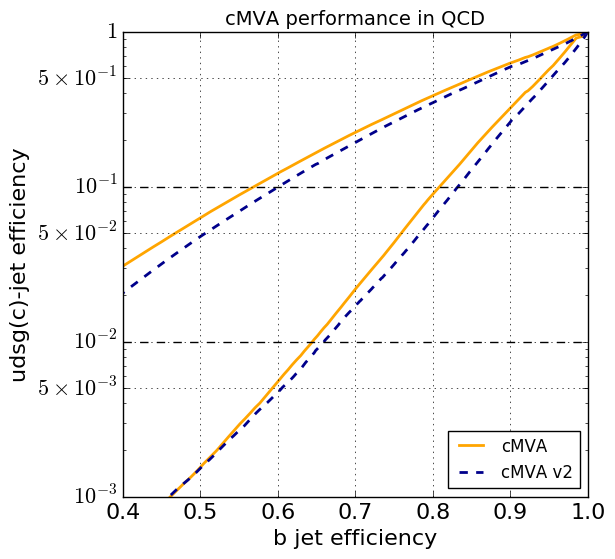

In [54]:
plt.figure(figsize=(6,6))
ax = plt.axes()
plt.grid()
r = draw_rocs([
    #(h01_qcd["b"], h01_qcd["l"], "AVR", {"color":"red"}),
    #(h02_qcd["b"], h02_qcd["l"], "IVF", {"color":"green"}),
    (h04_qcd["b"], h04_qcd["l"], "cMVA", {"color":"orange", "lw":2}),
    (h05_qcd["b"], h05_qcd["l"], "cMVA v2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["l"], "tmva", {"color":"orange"}),
    #(h1["b"], h1["l"], "c1", {"color": "grey", "lw":1}),
    #(h2["b"], h2["l"], "c2", {"color": "black", "lw":1}),
    #(h3["b"], h3["l"], "cMVA (scikit-learn)", {"color": "purple", "lw":1}),
    #(h4["b"], h4["l"], "c4", {"color": "cyan", "lw":1}),
])

plt.legend(loc=4)
r = draw_rocs([
    #(h01_qcd["b"], h01_qcd["c"], "AVR", {"color":"red"}),
    #(h02_qcd["b"], h02_qcd["c"], "IVF", {"color":"green"}),
    (h04_qcd["b"], h04_qcd["c"], "cMVA", {"color":"orange", "lw":2}),
    (h05_qcd["b"], h05_qcd["c"], "cMVA v2", {"color":"darkblue", "lw":2, "ls":"--"}),
    #(h04["b"], h04["c"], "tmva", {"color":"orange"}),
    #(h1["b"], h1["c"], "c1", {"color": "grey", "lw":1}),
    #(h2["b"], h2["c"], "c2", {"color": "black", "lw":1}),
    #(h3_qcd["b"], h3_qcd["c"], "cMVA (scikit-learn)", {"color": "purple", "lw":1}),
    #(h4["b"], h4["c"], "c4", {"color": "cyan", "lw":1}),
])

plt.yscale("log")

a = [0.5, 1.0]
a = [0.001, 0.005, 0.01, 0.05, 0.1] + list(a)
plt.yticks(a, a)
plt.xlim(0.4,1.0)
plt.ylim(0.001,1.0)
plt.axhline(0.01, color="black", ls="--")
plt.axhline(0.1, color="black", ls="--")

plt.xticks(np.linspace(0.4,1.0,7), fontsize=16)
plt.ylabel("udsg(c)-jet efficiency", fontsize=16)
plt.xlabel("b jet efficiency", fontsize=16)
plt.title(u"cMVA performance in QCD", fontsize=14)
ax.set_yticklabels(
    ["$10^{-3}$", "$5 \\times 10^{-3}$", "$10^{-2}$", "$5 \\times 10^{-2}$", "$10^{-1}$", "$5 \\times 10^{-1}$", "$1$"],
    fontsize=16
)
plt.savefig("cmva_vs_cmvav2_roc_perf_qcd.pdf")

### BDT distributions.

In [55]:
def plot_distributions(h1, h2, h3, rebin=1):
    plt.figure(figsize=(6,6))
    plt.grid()
    h1 = h1.Clone()
    h2 = h2.Clone()
    h3 = h3.Clone()
    for h in [h1, h2, h3]:
        h.Scale(1.0 / h.Integral())
        h.Rebin(rebin)
    h1.color = "red"
    h2.color = "blue"
    h3.color = "green"

    rplt.errorbar(h1, label="b", lw=1)
    rplt.errorbar(h2, label="c", lw=1)
    rplt.errorbar(h3, label="l", lw=1)
    plt.legend(loc="best")
    rplt.hist(h1, label="b", lw=2)
    rplt.hist(h2, label="c", lw=2)
    rplt.hist(h3, label="l", lw=2)


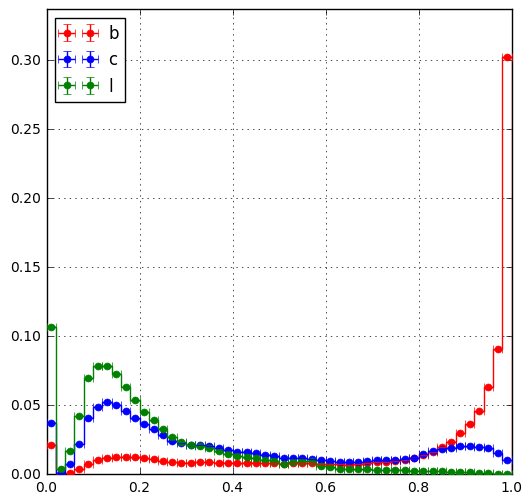

In [56]:
plot_distributions(h01["b"], h01["c"], h01["l"], rebin=5)

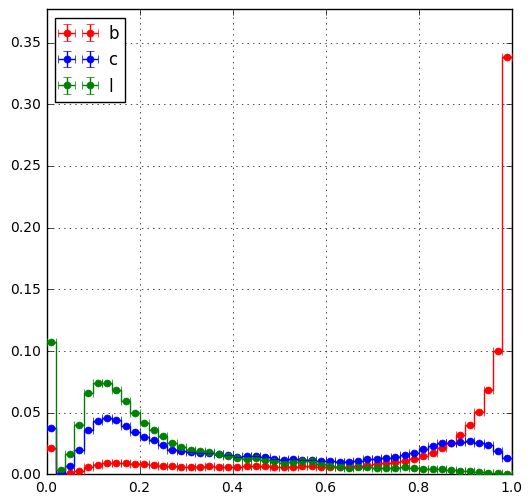

In [57]:
plot_distributions(h02["b"], h02["c"], h02["l"], rebin=5)

In [58]:
plot_distributions(h03["b"], h03["c"], h03["l"], rebin=5)
plt.yscale("log")
plt.ylim(0.0001, 1.0)
plt.xlabel("cMVA")

NameError: name 'h03' is not defined

In [ ]:
plot_distributions(h05["b"], h05["c"], h05["l"], rebin=5)
plt.yscale("log")
plt.ylim(0.0001, 1.0)
plt.xlabel("cMVA v2")

In [ ]:
plot_distributions(h1["b"], h1["c"], h1["l"], rebin=10)
plt.yscale("log")
plt.ylim(0.0001, 1.0)

In [ ]:
plot_distributions(h2["b"], h2["c"], h2["l"], rebin=5)
plt.yscale("log")
plt.ylim(0.0001, 1.0)

In [ ]:
plot_distributions(h3["b"], h3["c"], h3["l"], rebin=5)
plt.yscale("log")
plt.ylim(0.0001, 1.0)

In [ ]:
plot_distributions(h4["b"], h4["c"], h4["l"], rebin=5)
plt.yscale("log")
plt.ylim(0.0001, 1.0)

In [ ]:
def get_eff_at(a, b, x):
    idx = a.searchsorted(x)
    return b[idx]

In [ ]:
def cls_ds_metrics(clss, d1, d2):
    
    hists = {}
    for cls in clss:
        ca = cum(cls.evaluate(d1))
        cb = cum(cls.evaluate(d2))
        hists[cls.name] = (ca, cb)

    for v in ["Jet_CSV", "Jet_CSVIVF", "Jet_CombMVANEW", "Jet_CombMVAETH"]:
        ca = cum(d1[v])
        cb = cum(d2[v])
        hists[v] = (ca, cb)
    ret = {}
    for v in hists.keys():
        ret[v] = {}
        ret[v]["AUC"] = 1.0 - metrics.auc(hists[v][0], hists[v][1])
        ret[v]["e50"] = 1.0 - get_eff_at(hists[v][0], hists[v][1], 1.0 - 0.5)
        ret[v]["e90"] = 1.0 - get_eff_at(hists[v][0], hists[v][1], 1.0 - 0.9)

        ret[v]["f0.01"] = 1.0 - get_eff_at(hists[v][1], hists[v][0], 1.0 - 0.01)
        ret[v]["f0.1"] = 1.0 - get_eff_at(hists[v][1], hists[v][0], 1.0 - 0.1)
        ret[v]["f0.3"] = 1.0 - get_eff_at(hists[v][1], hists[v][0], 1.0 - 0.3)

    return ret

In [ ]:
gpt1 = d_qcd.groupby("ptbin2")
gpt2 = d_qcd.groupby("etabin2")

In [ ]:
gpt1 = d.groupby("ptbin2")
gpt2 = d.groupby("etabin2")

#gpt2 = df_tt_testing_shuf.groupby("ptbin")
#gpt3 = df_qcd_training.groupby("ptbin")

In [ ]:
xs_l = gpt1.apply(lambda d: cls_ds_metrics([cls_c4], d[d["id"]==2], d[d["id"]==0]))
xs_c = gpt1.apply(lambda d: cls_ds_metrics([cls_c4], d[d["id"]==2], d[d["id"]==1]))

In [ ]:
xs_l2 = gpt2.apply(lambda d: cls_ds_metrics([cls_c1, cls_c2, cls_c3, cls_c4], d[d["id"]==2], d[d["id"]==0]))
xs_c2 = gpt2.apply(lambda d: cls_ds_metrics([cls_c1, cls_c2, cls_c3, cls_c4], d[d["id"]==2], d[d["id"]==1]))

In [ ]:
def draw_comparison(xs1, bins, xlabel, ylabel, v):
    plt.figure(figsize=(6,6))

    ax = plt.axes([0,0.52,1.0,0.5])
    ax.grid()
    
    #ax.plot(bins[xs1.keys()-1], [x["c1"][v] for x in xs1], label="c1", ms=0, marker="x", lw=1, color="gray")
    #ax.plot(bins[xs1.keys()-1], [x["c2"][v] for x in xs1], label="c2", ms=0, marker="x", lw=1, color="purple")
    #ax.plot(bins[xs1.keys()-1], [x["c3"][v] for x in xs1], label="c3", ms=0, marker="x", lw=1, color="blue")
    #ax.plot(bins[xs1.keys()-1], [x["c4"][v] for x in xs1], label="c4", ms=0, marker="x", lw=1, color="cyan")
    #ax.plot(bins[xs1.keys()-1], [x["Jet_CSV"][v] for x in xs1], label="AVR", ms=0, marker="o", lw=1, color="red")
    ax.plot(bins[xs1.keys()-1], [x["Jet_CSVIVF"][v] for x in xs1], label="IVF", ms=0, marker="^", lw=1, color="green")
    ax.plot(bins[xs1.keys()-1], [x["Jet_CombMVANEW"][v] for x in xs1], label="cMVA", ms=0, marker="^", lw=2, color="orange")
    ax.plot(bins[xs1.keys()-1], [x["Jet_CombMVAETH"][v] for x in xs1], label="cMVA v2", ms=0, marker="^", lw=2, color="darkblue", ls="--")
    ax.legend(loc="best")

    ax.set_ylabel(ylabel, fontsize=16)

    ax = plt.axes([0,0.0,1.0,0.48], sharex=ax)
    ax.grid()

    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel("classifier wrt. cMVA", fontsize=16)

    #ax.plot(bins[xs1.keys()-1], [x["Jet_CSV"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=1, color="red")
    ax.plot(bins[xs1.keys()-1], [x["Jet_CSVIVF"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=2, color="green")
    ax.plot(bins[xs1.keys()-1], [x["Jet_CombMVAETH"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=2, color="darkblue", ls="--")

    #ax.plot(bins[xs1.keys()-1], [x["c1"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=1, color="gray")
    #ax.plot(bins[xs1.keys()-1], [x["c2"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=1, color="purple")
    #ax.plot(bins[xs1.keys()-1], [x["c3"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=1, color="blue")
    #ax.plot(bins[xs1.keys()-1], [x["c4"][v]/ x["Jet_CombMVANEW"][v] for x in xs1], ms=0, marker="^", lw=1, color="cyan")
    ax.axhline(1.0, color="orange", lw=2)
    #ax.set_ylim(top=1.2)

In [ ]:
draw_comparison(xs_l, ptbins2,
    "jet $p_T$ [GeV]",
    "AUC light",
    "AUC"
)
plt.savefig("discr_comparison_pt_auc_light.pdf")

In [ ]:
draw_comparison(xs_l2, etabins2,
    "jet $|\eta|$",
    "AUC light",
    "AUC"
)
plt.savefig("discr_comparison_eta_auc_light.pdf")

In [ ]:
draw_comparison(xs_c, ptbins2,
    "jet $p_T$ [GeV]",
    "AUC charm",
    "AUC"
)
plt.savefig("discr_comparison_pt_auc_charm.pdf")

In [ ]:
draw_comparison(xs_c2, etabins2,
    "jet $|\eta|$",
    "AUC charm",
    "AUC"
)
plt.savefig("discr_comparison_eta_auc_charm.pdf")

In [ ]:
draw_comparison(xs_l, ptbins2,
    "jet $p_T$ [GeV]",
    "udsg eff. at 50% b-eff.",
    "e50"
)
plt.savefig("discr_comparison_pt_e50_light.pdf")

In [ ]:
draw_comparison(xs_l2, etabins2,
    "jet $|\eta|$",
    "udsg eff. at 50% b-eff",
    "e50"
)
plt.savefig("discr_comparison_eta_e50_light.pdf")

In [ ]:
draw_comparison(xs_l, ptbins2,
    "jet $p_T$ [GeV]",
    "udsg eff. at 90% b eff.",
    "e90"
)
plt.savefig("discr_comparison_pt_e90_light.pdf")

In [ ]:
draw_comparison(xs_l2, etabins2,
    "jet $|\eta|$",
    "udsg eff. at 90% b eff.",
    "e90"
)
plt.savefig("discr_comparison_eta_e90_light.pdf")

In [ ]:
draw_comparison(xs_c, ptbins2,
    "jet $p_T$ [GeV]",
    "c eff. at 50% b eff.",
    "e50"
)
plt.savefig("discr_comparison_pt_e50_charm.pdf")

In [ ]:
draw_comparison(xs_c2, etabins2,
    "jet $|\eta|$",
    "c eff. at 50% b eff.",
    "e50"
)
plt.savefig("discr_comparison_eta_e50_charm.pdf")

In [ ]:
draw_comparison(xs_c, ptbins2,
    "jet $p_T$ [GeV]",
    "c eff. at 90% b eff.",
    "e90"
)
plt.savefig("discr_comparison_pt_e90_charm.pdf")

In [ ]:
draw_comparison(xs_c2, etabins2,
    "jet $|\eta|$",
    "c eff. at 90% b eff.",
    "e90"
)
plt.savefig("discr_comparison_eta_e90_charm.pdf")

In [ ]:
draw_comparison(xs_l, ptbins2,
    "jet $p_T$ [GeV]",
    "b eff. at 10% udsg eff.",
    "f0.1"
)
plt.savefig("discr_comparison_pt_beff_udsg01.pdf")

In [ ]:
draw_comparison(xs_l, ptbins2,
    "jet $p_T$ [GeV]",
    "b eff. at 1% udsg eff.",
    "f0.01"
)
plt.savefig("discr_comparison_pt_beff_udsg001.pdf")

In [ ]:
draw_comparison(xs_c, ptbins2,
    "jet $p_T$ [GeV]",
    "b eff at 30% c eff.",
    "f0.3"
)
plt.savefig("discr_comparison_pt_beff_c03.pdf")

In [ ]:
plt.figure(figsize=(6,5))
xx, yy = np.meshgrid(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000))
N = len(xx.ravel())
a = np.c_[xx.ravel(), yy.ravel()]
b = np.zeros((N, 6))
b[:, 0:2] = a[:, :]
bd_jp = 0.4
bd_sel = 0.0
bd_smu = 0.0
vtxcat = 0
b[:, 2] = bd_jp
b[:, 3] = bd_sel
b[:, 4] = bd_smu
b[:, 5] = bd_smu


Z = cls_c3.cls.predict_proba(b)
z = Z[:, 1]
z = z.reshape(xx.shape)
cont = plt.contourf(xx, yy, z, alpha=1, cmap="coolwarm")
plt.colorbar(cont, label="discriminator")
Nplot = 100
sel = (
    (d_testing["Jet_JP"]>bd_jp-0.1) & (d_testing["Jet_JP"]<bd_jp+0.1) &
    (d_testing["Jet_SoftEl"]>bd_sel-0.1) & (d_testing["Jet_SoftEl"]<bd_sel+0.1) &
    (d_testing["Jet_SoftMu"]>bd_smu-0.1) & (d_testing["Jet_SoftMu"]<bd_smu+0.1) & 
    abs(d_testing["Jet_CSV"] - d_testing["Jet_CSVIVF"])>0.00001
)

print sum(sel)
s1 = d_testing["id"]==2
s2 = d_testing["id"]==0
s3 = d_testing["id"]==1

plt.scatter(
    d_testing[sel & s1][:Nplot]["Jet_CSV"],
    d_testing[sel & s1][:Nplot]["Jet_CSVIVF"],
    marker="o", alpha=1.0, color="black",
    label="b"
)

plt.scatter(
    d_testing[sel & s2][:Nplot]["Jet_CSV"],
    d_testing[sel & s2][:Nplot]["Jet_CSVIVF"],
    marker="x", alpha=1.0, color="red",
    label="udsg"
)

plt.scatter(
    d_testing[sel & s3][:Nplot]["Jet_CSV"],
    d_testing[sel & s3][:Nplot]["Jet_CSVIVF"],
    marker="^", alpha=1.0, color="green",
    label="c"
)
plt.legend(numpoints=1, loc=3)
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel("CSV AVR", fontsize=16)
plt.ylabel("CSV IVF", fontsize=16)

In [ ]:
# evaluate_tmva(d, "CombinedMVAETH.weights.xml", cls_c3.variables)